## Amazon chronos-t5-small models for predicting stock's price

https://huggingface.co/amazon/chronos-t5-small

In [1]:
# %pip install git+https://github.com/amazon-science/chronos-forecasting.git
# !pip install transformers

In [2]:
import yfinance as yf
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from chronos import ChronosPipeline

# Dataset 

In [3]:
# 1. fetch data
GetTSLA = yf.Ticker("TSLA")
df_full = GetTSLA.history(start="2023-01-01", end="2025-12-31")
df_full.reset_index(inplace=True)

# 2. split train and test
df_full["Date"] = pd.to_datetime(df_full["Date"])
df_train = df_full[df_full["Date"] < "2025-01-01"]
df_test = df_full[df_full["Date"] >= "2025-01-01"]

# Apply Chronos model 

In [4]:
# 3. load Chronos pipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    torch_dtype=torch.bfloat16,
)

# 4. context
context = torch.tensor(df_train["Close"].values, dtype=torch.float32)

# 5. predict
prediction_length = len(df_test)
forecast = pipeline.predict(context, prediction_length=prediction_length)

# 6. confidence interval : 30%, 50%, 80%
low, median, high = np.quantile(forecast[0].numpy(), [0.3, 0.5, 0.8], axis=0)

# 7. index and actual
forecast_index = df_test["Date"].values
actual_2025 = df_test["Close"].values

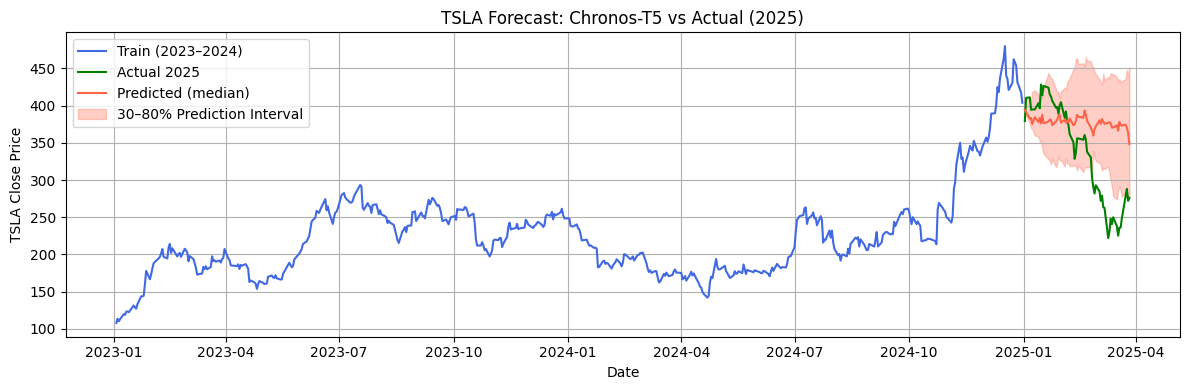

In [5]:
# 8. visualize
plt.figure(figsize=(12, 4))
# plt.plot(df_full["Date"], df_full["Close"], color="lightgray", label="Full Historical Data")
plt.plot(df_train["Date"], df_train["Close"], color="royalblue", label="Train (2023–2024)")
plt.plot(forecast_index, actual_2025, color="green", label="Actual 2025")
plt.plot(forecast_index, median, color="tomato", label="Predicted (median)")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="30–80% Prediction Interval")
plt.title("TSLA Forecast: Chronos-T5 vs Actual (2025)")
plt.xlabel("Date")
plt.ylabel("TSLA Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(actual_2025, median)
mse = mean_squared_error(actual_2025, median)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 58.9308
MSE: 5585.5116
RMSE: 74.7363


In [7]:
#load pickle file 
import pickle

with open("results_matrix.pkl","rb") as f:
    matrix = pickle.load(f)
    
matrix

# Add the Chronos model's metrics to the matrix
matrix.loc["chronos"] = [mae, mse, rmse]

matrix

,MAE,MSE,RMSE
ARIMA,63.930755,6925.833442,83.221592
timesfm,39.170328,2699.699230,51.958630
chronos,58.930795,5585.511586,74.736280


In [10]:
# save matrix to pickle file
with open("results_matrix.pkl", "wb") as f:
    pickle.dump(matrix, f)

In [11]:
matrix.to_csv("result_matrix.csv", index=True)  